<font size="8">Customer churn prediction model - Telecom</font>

<font size="4">by: Utkarsh Singh</font>

# Import libraries

In [1]:
import pandas as pd, numpy as np, scipy as sp, sklearn , matplotlib.pyplot as plt, seaborn as sns,plotly as ply, statsmodels, warnings

In [2]:
import os
os.chdir("C:\\Users\\Hi\\Documents\\UC BANA Master\\Data science - Python\\telco-customer-churn - Kaggle")

# Define functions

In [59]:
# Obtain frequency for all categorical variables

def categorical_var_freq(df):
    x=0
    while x < len(list(df.select_dtypes(include = "object").columns)):
        varname = list(df.select_dtypes(include = "object").columns)[x]
        print(varname,"\n")
        print(pd.DataFrame(df[varname].value_counts()),"\n")
        x=x+1

        
# Cramer's V statistic for measuring association between categorical predictors

import scipy.stats as ss

def cramers_v(X,Y):
    confusion_matrix = pd.crosstab(X,Y).values
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Symmetric misclassification using p threshold

def symm_misclassif(y_true,y_pred,p): 
    FP = np.sum((y_pred.reshape((y_true.shape[0],1))>p) & (y_true==0)) 
    FN = np.sum((y_pred.reshape((y_true.shape[0],1))<=p) & (y_true==1)) 
    misclassification = FP+FN 
    misclassification_rate = misclassification/y_true.shape[0] 
    return misclassification_rate

# Asymmetric misclassification using p threshold and 1:3 class weights for 0:1

def asymm_misclassif(y_true,y_pred,p): 
    FP = (y_pred.reshape((y_true.shape[0],1))>p) & (y_true==0)
    FN = (y_pred.reshape((y_true.shape[0],1))<=p) & (y_true==1)
    misclassification_rate = np.mean(FP+np.multiply(FN,3))
    return misclassification_rate

# Read raw data

In [4]:
churndata = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [8]:
churndata.shape

(7043, 21)

In [83]:
display(churndata.iloc[1:10,:])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,response
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,0
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


# Data quality

In [9]:
# Columns

churndata.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Convert datatype of TotalCharges column
churndata['TotalCharges'].replace(" ",np.nan,inplace=True)
churndata['TotalCharges'] = churndata['TotalCharges'].astype("float")

In [6]:
# Primary key uniqueness

print(churndata['customerID'].nunique())
print(churndata.shape)

7043
(7043, 21)


In [5]:

churndata.isna().sum()

# test = churndata.dropna(axis=0)
# test.to_csv("TelcoChurnClean.csv")

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

**11** missing values found in the column TotalCharges.

# Data Exploration

## Convert response variable into integer 0/1

In [6]:
churndata['response'] = churndata['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
churndata.drop(['Churn'],axis=1,inplace=True)
display(churndata)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,response
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


## Stacked bar: All categorical variables vs response

Let us look at the distribution of the response variable across levels of each categorical variable

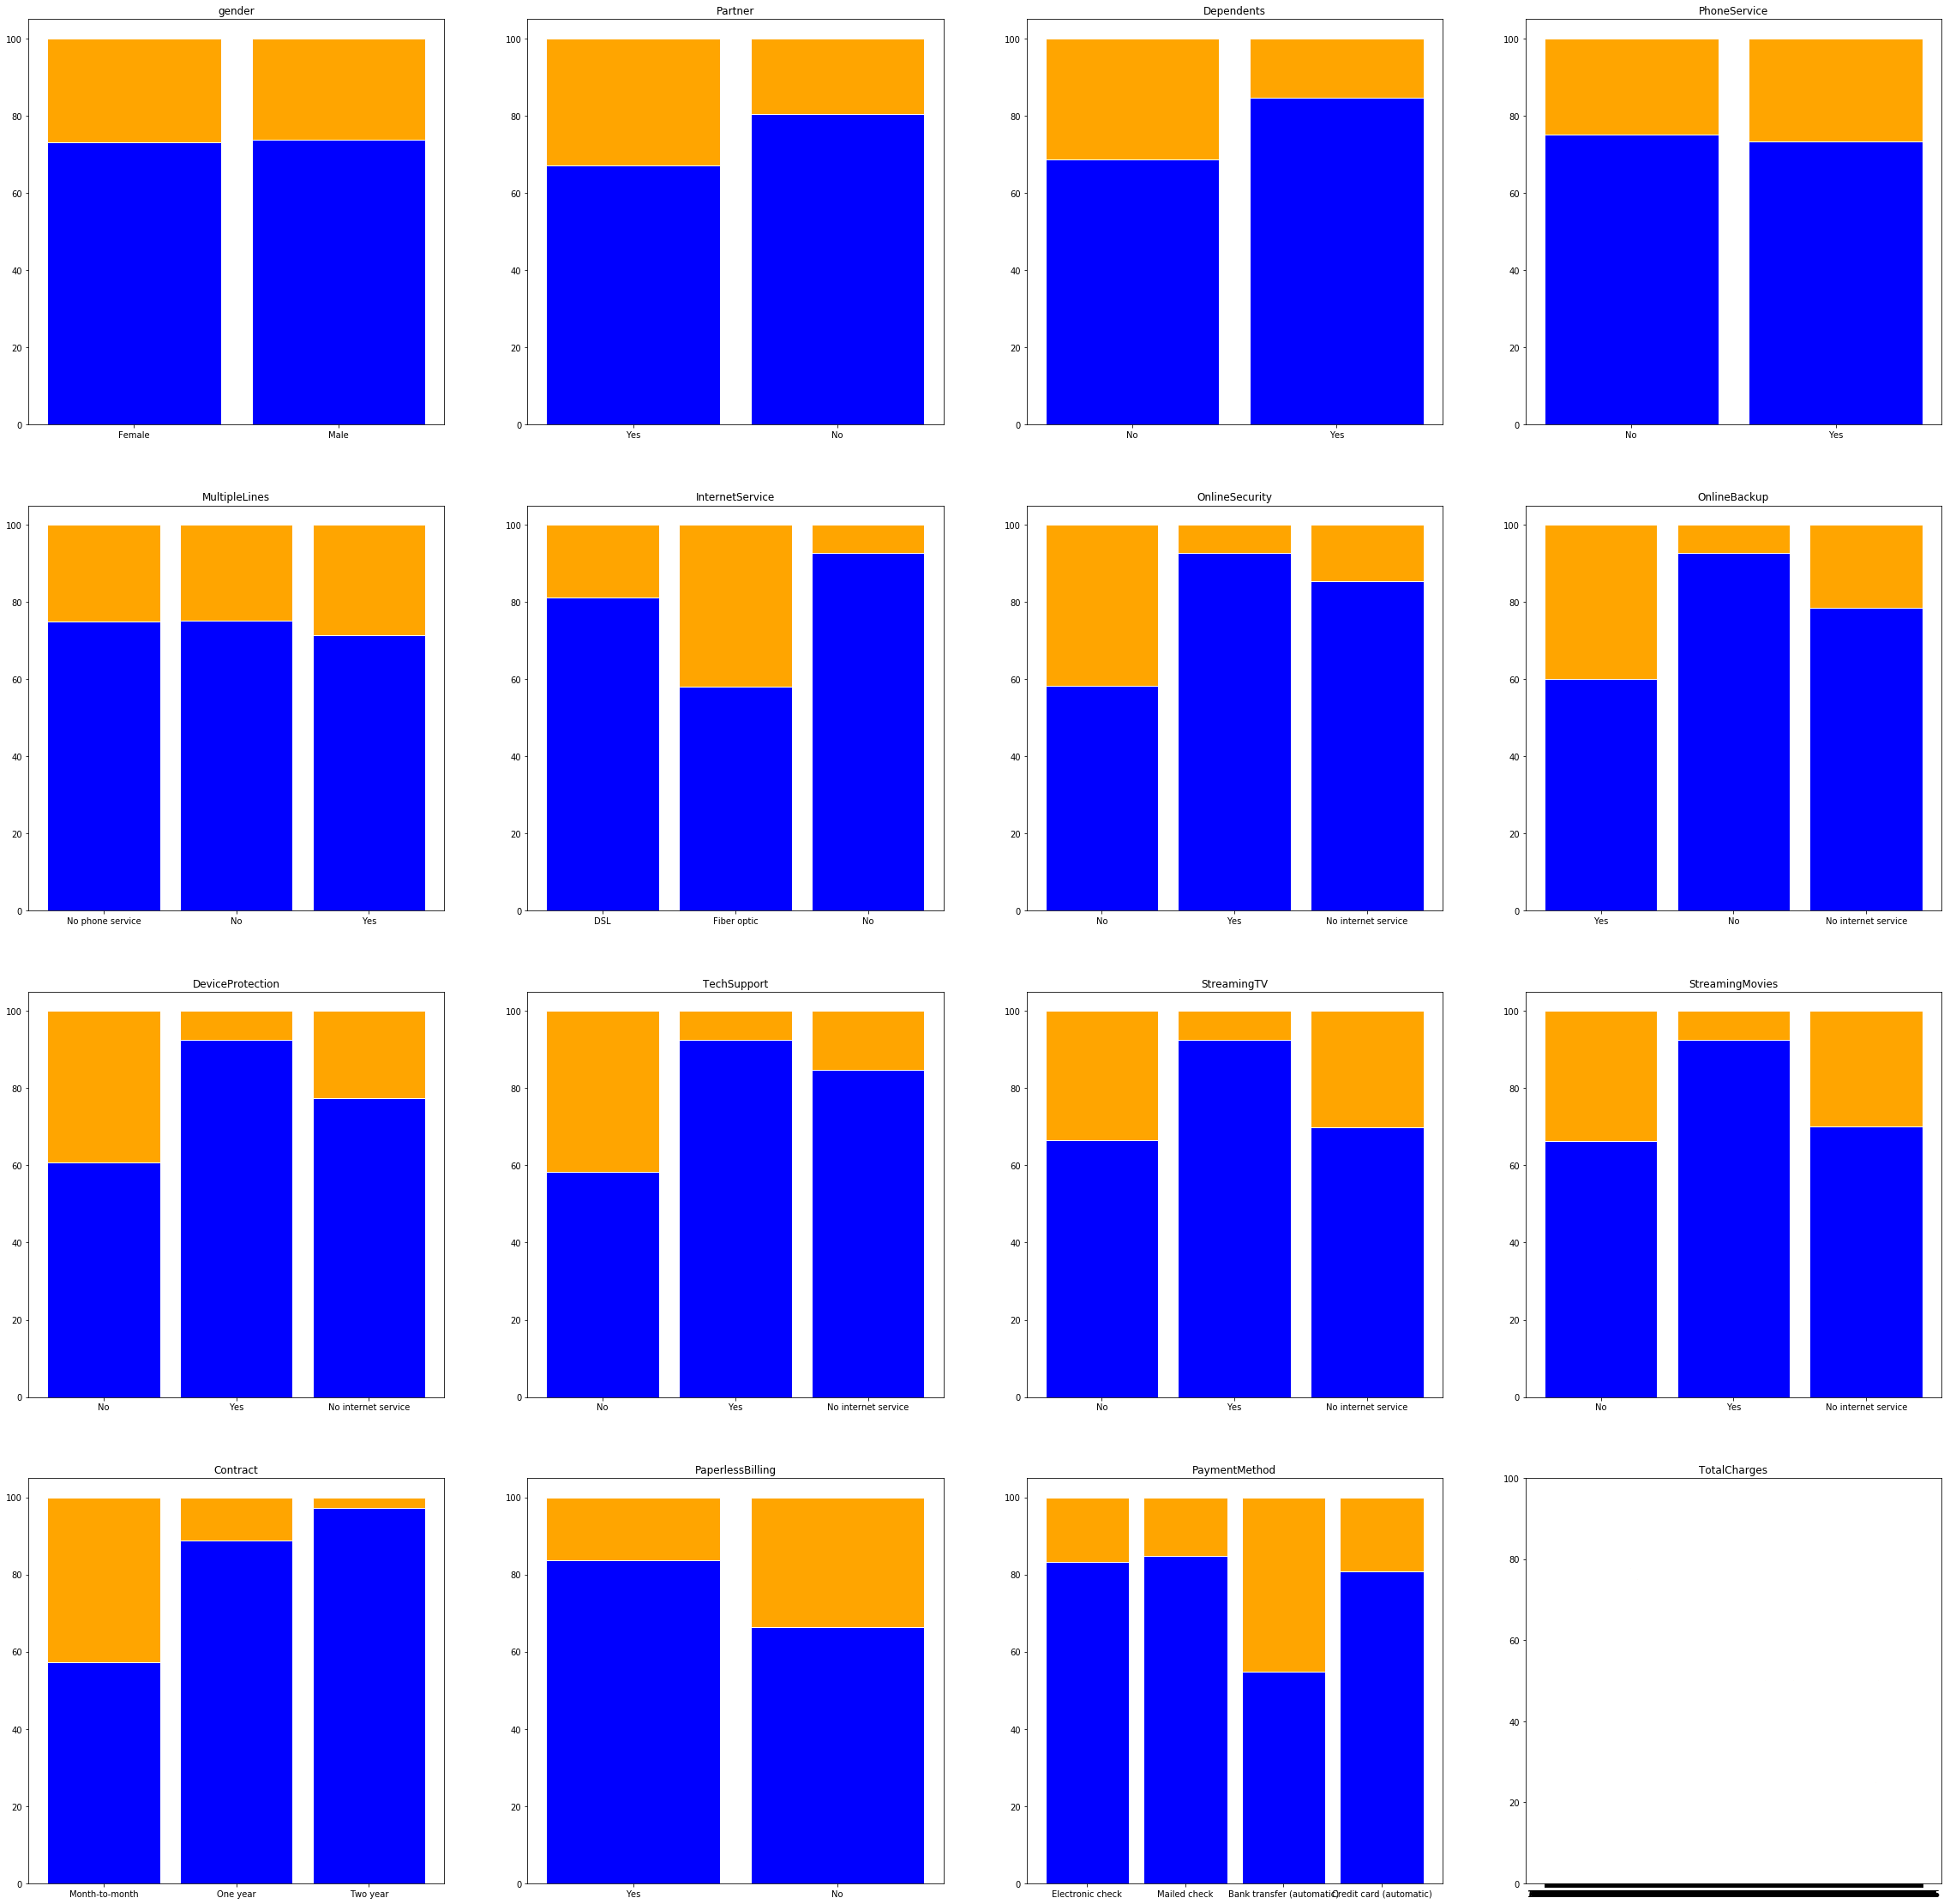

In [82]:
df = churndata.copy()
target = 'response'
dataid = 'customerID'

categcolnames = list(df.select_dtypes(include = "object").columns)
categcolnames.remove('customerID')




fig, axes = plt.subplots(4, 4, figsize=(40,40))


for var,ax in zip(categcolnames,axes.flatten()):

    plotdf1 = df[[dataid,target,var]].groupby([var,target])[[dataid]].nunique().reset_index().pivot(index = var,columns = target,values =dataid).reset_index().replace(np.nan,0)
    totals = [i+j for i,j in zip(plotdf1[0], plotdf1[1])]
    nonevents = [i / j * 100 for i,j in zip(plotdf1[0], totals)]
    events = [i / j * 100 for i,j in zip(plotdf1[1], totals)]

    barWidth = 0.85
    names = df[var].unique()
    r = list(range(len(names)))
    # Create nonevents bar
    ax.bar(r, nonevents, color='blue', edgecolor='white', width=barWidth)
    # Create events Bars
    ax.bar(r, events, bottom=nonevents, color='orange', edgecolor='white', width=barWidth)
    # Custom x axis
#     ax.xticks(r, names, rotation=45)
    ax.set_title(var)
    ax.set_xticks(r)
    ax.set_xticklabels(names)


## Histograms - Continuous variables vs response

Let us now check distribution of continuous variables for the churn and non-churn customers

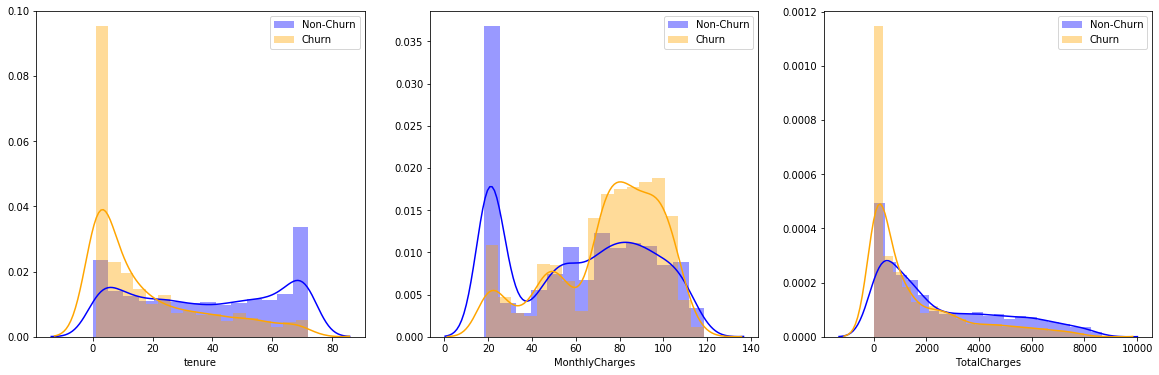

In [103]:
warnings.simplefilter('ignore')

df0 = churndata[churndata['response']==0]
df1 = churndata[churndata['response']==1]

numericcolnames = list(df.select_dtypes(exclude = "object").columns)

fig, axes = plt.subplots(1, 3, figsize=(20,6))

for var,axe in zip(numericcolnames,axes.flatten()):
    sb.distplot(df0[var],color="blue",label='Non-Churn',ax=axe);
    sb.distplot(df1[var],color="orange",label='Churn',ax=axe);
    axe.legend(loc='best');


<br>

There is a significant difference between the distributions of **Tenure** and **Monthly Charges** for Churned and Retained customers

## Class proportion

In [8]:
print('proportion of churned customers is: ',np.around((churndata['response'].mean())*100,decimals=2),'%')

proportion of churned customers is:  26.54 %


## Variable Summary

In [8]:
churndata.drop(['customerID'],axis=1).describe(include="all")

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,response
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043.000000
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,NaN
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,NaN
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,NaN
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,0.265370
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,0.441561
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,0.000000
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,0.000000
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,0.000000
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,1.000000


In [19]:
categorical_var_freq(churndata.drop(['customerID'],axis=1))

gender 

        gender
Male      3555
Female    3488 

SeniorCitizen 

   SeniorCitizen
0           5901
1           1142 

Partner 

     Partner
No      3641
Yes     3402 

Dependents 

     Dependents
No         4933
Yes        2110 

PhoneService 

     PhoneService
Yes          6361
No            682 

MultipleLines 

                  MultipleLines
No                         3390
Yes                        2971
No phone service            682 

InternetService 

             InternetService
Fiber optic             3096
DSL                     2421
No                      1526 

OnlineSecurity 

                     OnlineSecurity
No                             3498
Yes                            2019
No internet service            1526 

OnlineBackup 

                     OnlineBackup
No                           3088
Yes                          2429
No internet service          1526 

DeviceProtection 

                     DeviceProtection
No                               30

*SeniorCitizen* flag should be an "object" type field, whereas *TotalCharges* should be float type. Make the necessary conversions

In [7]:
churndata['SeniorCitizen'] = churndata['SeniorCitizen'].astype('object')

## Categorical correlation between variables - Cramer's V

As our feature space is predominantly categorical in nature, let us run a cramer's V  test to study association between variables

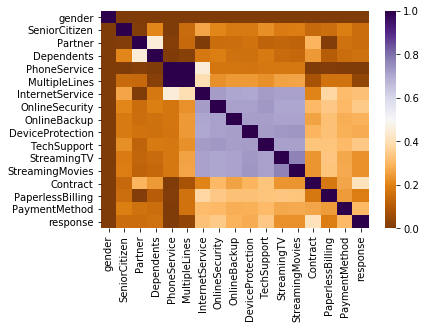

In [14]:
df = churndata.drop(['customerID'],axis=1)
df['response'] = df['response'].astype('object') 
categcols = list(df.select_dtypes(include = "object").columns)
assoc_table = np.empty((len(categcols),len(categcols)))
i=0
j=0

while i<len(categcols):
    while j<len(categcols):
        v1=df[categcols[i]]
        v2=df[categcols[j]]
        assoc_table[i,j] = cramers_v(v1,v2)
        j=j+1
    i=i+1
    j=0

assoc_data = pd.DataFrame(assoc_table,index=categcols,columns=categcols)
# display(assoc_data)

sb.heatmap(assoc_data, cmap='PuOr');

# Data Preprocessing

## Binary encoding of categorical variables

In [8]:
categ_cols = list(churndata.select_dtypes(include="object").columns)
categ_cols.remove('customerID')

churndata_v2 = churndata.copy()
for col in categ_cols:
    churndata_v2 = pd.concat([churndata_v2,pd.get_dummies(churndata[col]).add_prefix(col+'_').iloc[:,:-1]],axis=1).drop([col],axis=1)

In [9]:
# drop rows containing NA values for now
churndata_v2.dropna(axis=0,inplace=True)
churndata_v2.shape

(7032, 32)

## Split Training and Test samples

In [10]:
from sklearn.model_selection import train_test_split
X = np.array(churndata_v2.drop(['response','customerID'],axis=1))
Y = np.array(churndata_v2[['response']])

Split the entire data into an 80% Train and a 20% Test sample. Map the column names back to the training dataframe consisting of the predictor variables

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state = 710)
x_train_df = pd.DataFrame(x_train, columns = churndata_v2.drop(['response','customerID'],axis=1).columns)

In [32]:
x_train_df.shape
x_train_df.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'TechSupport_No', 'TechSupport_No internet service', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'Contract_Month-to-month',
       'Contract_One year', 'PaperlessBilling_No',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check'],
      dtype='object')

# Statistical inference

In [22]:
import statsmodels.api as sm

## Fit logit model

In [25]:
X = x_train
y = y_train

logisticmod = sm.Logit(y,X)

In [37]:
#Fit the model on training data
result = logisticmod.fit()

Optimization terminated successfully.
         Current function value: 0.410565
         Iterations 8


## Parameter Estimation Table

In [117]:
# Sort based on the pvalues and obtain the index
sorted_idx = np.argsort(result.pvalues)

feature_names = np.array(x_train_df.columns)[sorted_idx] # get feature names based on index
feature_weights = result.params[sorted_idx] #get coefficient values
weights_stderror = result.bse[sorted_idx]  # get std. error
pvalues = result.pvalues[sorted_idx]  # get p-values
CI_lower = result.conf_int()[:,0][sorted_idx]
CI_upper = result.conf_int()[:,1][sorted_idx]

coefficients_table = pd.DataFrame({'Variable':feature_names,'Coefficient':feature_weights,'stderror':weights_stderror,'pvalue':pvalues,'CI_lower':CI_lower,'CI_upper':CI_upper},columns=['Variable','Coefficient','stderror','pvalue','CI_lower','CI_upper'])

coefficients_table

,Variable,Coefficient,stderror,pvalue,CI_lower,CI_upper
0,tenure,-0.061698,7.019159e-03,1.497002e-18,-7.545496e-02,-4.794037e-02
1,Contract_One year,0.773740,1.171892e-01,4.043307e-11,5.440529e-01,1.003426e+00
2,TotalCharges,0.000336,7.970847e-05,2.464598e-05,1.799860e-04,4.924375e-04
3,PaperlessBilling_No,-0.326100,8.440677e-02,1.118061e-04,-4.915338e-01,-1.606654e-01
4,PaymentMethod_Electronic check,0.374857,1.084894e-01,5.498046e-04,1.622215e-01,5.874922e-01
5,SeniorCitizen_0,-0.302645,9.374260e-02,1.244549e-03,-4.863772e-01,-1.189129e-01
6,MultipleLines_No,-0.375647,2.009277e-01,6.154419e-02,-7.694585e-01,1.816357e-02
7,StreamingMovies_No,-0.601554,3.637142e-01,9.814402e-02,-1.314421e+00,1.113130e-01
8,StreamingTV_No,-0.501422,3.640224e-01,1.683736e-01,-1.214893e+00,2.120487e-01
9,TechSupport_No,0.240400,1.933372e-01,2.137118e-01,-1.385339e-01,6.193338e-01


<br>

Statistically significant features: **Total Charges**, **Tenure**, **Senior Citizen(Yes/No)**,**Paperless billing(Yes/No)**, **Payment Method**, **Multiple lines**, **Streaming Movies(Yes/No)**,**Contract type**

# Feature engineering

## LASSO feature selection

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso=Lasso(max_iter=10000)
param_grid = {'alpha':[1e-10,1e-8,1e-6,1e-4,1e-2,0.1,0.5,1,1.5,2,3,4,5]}
lasso_gridcv = GridSearchCV(lasso,param_grid,scoring="roc_auc",cv=5)
lasso_gridcv.fit(x_train,y_train)

C:\Users\Hi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Hi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Hi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Hi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cau

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-10, 1e-08, 1e-06, 0.0001, 0.01, 0.1, 0.5, 1, 1.5, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

([<matplotlib.axis.XTick at 0x21c29fe85f8>,
 <a list of 13 Text xticklabel objects>)

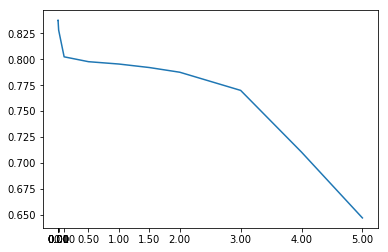

In [80]:
plt.plot(param_grid['alpha'],lasso_gridcv.cv_results_['mean_test_score']) 
plt.xticks([1e-10,1e-8,1e-6,1e-4,1e-2,0.1,0.5,1,1.5,2,3,4,5])

In [25]:
print(lasso_gridcv.best_params_)

{'alpha': 0.0001}


optimum alpha value selected through 5-fold CV is 0.0001. Next,we will fit a lasso model with the optimal alpha value to see which variables are eliminated from the model

In [26]:
lasso_opt = Lasso(alpha=0.0001,max_iter=10000).fit(x_train,y_train)

In [27]:
var = pd.DataFrame(x_train_df.columns, columns=["predictor"])
coef = pd.DataFrame(lasso_opt.coef_, columns=["lasso.coef"])
varselectiontable = pd.concat([var,coef],axis=1)
display(varselectiontable.sort_values(by=['lasso.coef'],ascending=False))
    

,predictor,lasso.coef
11,InternetService_Fiber optic,0.127276
29,PaymentMethod_Electronic check,0.075957
18,TechSupport_No,0.066932
24,Contract_Month-to-month,0.064441
0,SeniorCitizen,0.058152
12,OnlineSecurity_No,0.054035
14,OnlineBackup_No,0.032527
7,PhoneService_No,0.032038
6,Dependents_No,0.015988
16,DeviceProtection_No,0.010474


The following variables are eliminated: **Gender**, **InternetService_DSL**,**OnlineSecurity_No internet service**, **OnlineBackup_No internet service**, **DeviceProtection_No internet service**,**TechSupport_No internet service**,**StreamingTV_No internet service**,**StreamingMovies_No internet service**

## Recursive feature elimination using Random Forest

We will use Recursive Feature Elimination using the Random Forest Classifier. We will try to do this by using a cost-sensitive model,  and will also optimize for the # of variables to be selected. We will calculate cost using the formula : *n_samples/(n_classes * n_sampleswithclass)* 

In [28]:
wt0= y_train.shape[0]/(2*np.count_nonzero(y_train==0))
wt1= y_train.shape[0]/(2*np.count_nonzero(y_train==1)) 
weights = {0:wt0,1:wt1}
print(weights)

{0: 0.6783646888567294, 1: 1.9016227180527383}


In [30]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define RF classifier model
rfmodel = RandomForestClassifier(n_estimators=100,random_state=710,class_weight = weights,n_jobs=-1)
# Define CV score array for auc scores
scores_array = np.empty((1,len(range(10,31,2))))

i=0
for n in list(range(10,31,2)):

    # Define RFE selector
    select = RFE(rfmodel,n_features_to_select=n)
    # Select features using x_train, y_train
    select.fit(x_train,np.ravel(y_train))
    # Create x_train_rfe as a subset of x_train consisting of only the selected features
    x_train_rfe= select.transform(x_train)
    # Obtain CV score (auc) using only selected features
    scores_array[0,i] = format(cross_val_score(rfmodel,x_train_rfe,np.ravel(y_train),cv=3,scoring="roc_auc").mean())
    i=i+1

print(scores_array)

[[0.81176436 0.81926029 0.82044523 0.82268302 0.82386112 0.82467938
  0.82437678 0.82296385 0.8224     0.8220086  0.82516739]]


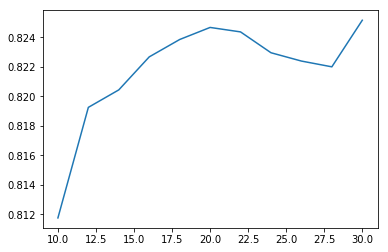

In [31]:
plt.plot(np.array(list(range(10,31,2))),scores_array.transpose())

The iterations suggest that the optimum number of features to be selected are **20**. Let us see what are the selected features

In [33]:
select = RFE(rfmodel,n_features_to_select=20)
select.fit(x_train,np.ravel(y_train))



RFE(estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.6783646888567294, 1: 1.9016227180527383},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=710,
            verbose=0, warm_start=False),
  n_features_to_select=20, step=1, verbose=0)

In [34]:
cols = list(x_train_df.columns)
temp = pd.Series(select.support_,index = cols)
# print(temp[temp==True])
print(temp.sort_values())



StreamingTV_No internet service            False
OnlineBackup_No internet service           False
PaymentMethod_Credit card (automatic)      False
OnlineSecurity_No internet service         False
TechSupport_No internet service            False
InternetService_DSL                        False
MultipleLines_No phone service             False
DeviceProtection_No internet service       False
StreamingMovies_No internet service        False
PhoneService_No                            False
TechSupport_No                              True
StreamingMovies_No                          True
StreamingTV_No                              True
Contract_Month-to-month                     True
Contract_One year                           True
PaperlessBilling_No                         True
PaymentMethod_Bank transfer (automatic)     True
SeniorCitizen                               True
OnlineBackup_No                             True
OnlineSecurity_No                           True
InternetService_Fibe

# Modeling

In [118]:
# We will move ahead with the following variables

selected_vars_index = [18,22,20,24,25,26,27,0,14,12,11,8,6,5,4,3,2,1,16,29,28,9,7]

In [119]:
x_train_selected = x_train[:,selected_vars_index]
x_test_selected = x_test[:,selected_vars_index]

In [38]:
x_train_selected.shape

(5625, 23)

## Logistic regression (L2 regularization)

### Fit model

In [144]:
X = x_train_selected
y = y_train

(5625, 1)

In [181]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

logreg = LogisticRegression()
custom_scorer1 = make_scorer(symm_misclassif,needs_proba=True)
custom_scorer2 = make_scorer(asymm_misclassif,needs_proba=True)

#### Select optimum cutoff based on overall misclassification

optimum probability - symmetric:  [0.5]
optimum probability - asymmetric:  [0.25]


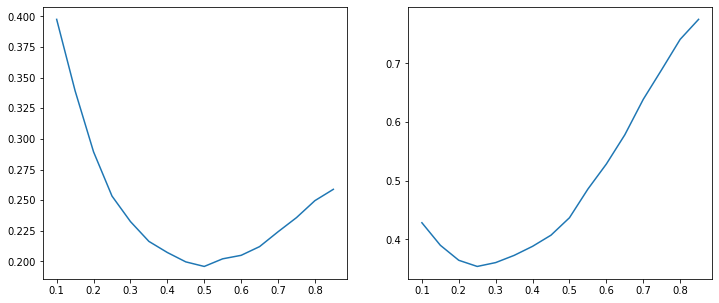

In [182]:
prob_array = np.around(np.arange(0.1,0.9,0.05), decimals=2) 
mean_crossvalscore_sym = np.zeros(prob_array.size)
mean_crossvalscore_asym = np.zeros(prob_array.size)
i=0 

for p in prob_array: 
    mean_crossvalscore_sym[i] =  cross_val_score(logreg,X,y,scoring=custom_scorer1,cv=3).mean()
    mean_crossvalscore_asym[i] =  cross_val_score(logreg,X,y,scoring=custom_scorer2,cv=3).mean()
    i=i+1 


fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(prob_array,mean_crossvalscore_sym);
ax[1].plot(prob_array,mean_crossvalscore_asym);

print('optimum probability - symmetric: ',prob_array[mean_crossvalscore_sym == np.min(mean_crossvalscore_sym)])
print('optimum probability - asymmetric: ',prob_array[mean_crossvalscore_asym == np.min(mean_crossvalscore_asym)])


#### Evaluate on Training sample

In [183]:
logreg.fit(X,y)

predicted = (logreg.predict_proba(X)[:,1].reshape((y.shape[0],1))>0.25)*1

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print('Confusion Matrix :')
print(confusion_matrix(y,predicted)) 
print('Accuracy Score :',accuracy_score(y, predicted))
print('Report : ')
print(classification_report(y, predicted))
print('AUC: ',roc_auc_score(y,predicted))

Confusion Matrix :
[[3006 1140]
 [ 294 1185]]
Accuracy Score : 0.7450666666666667
Report : 
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      4146
           1       0.51      0.80      0.62      1479

    accuracy                           0.75      5625
   macro avg       0.71      0.76      0.72      5625
weighted avg       0.81      0.75      0.76      5625

AUC:  0.763126608994813


### Evaluate model on Test

In [184]:
predicted_test = (logreg.predict_proba(x_test_selected)[:,1].reshape((y_test.shape[0],1))>0.25)*1

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

print('Confusion Matrix :')
print(confusion_matrix(y_test,predicted_test)) 
print('Accuracy Score :',accuracy_score(y_test, predicted_test))
print('Report : ')
print(classification_report(y_test, predicted_test))

Confusion Matrix :
[[731 286]
 [ 73 317]]
Accuracy Score : 0.7448471926083866
Report : 
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1017
           1       0.53      0.81      0.64       390

    accuracy                           0.74      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.80      0.74      0.76      1407



## XGBoost

### Preprocessing feature set

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_Scaled = scaler.transform(x_test)

### Model configuration and Parameter tuning

In [13]:
# import xgboost
from xgboost import XGBClassifier

In [14]:
# Objective
objective_func = 'binary:logistic'
# Class weights
sum_pos = np.sum(y_train)
sum_neg = len(y_train) - sum_pos
weight = sum_neg/sum_pos

#### Randomized search for tuning learning rate and n_estimators

In [15]:
# Define model
xgb = XGBClassifier(objective=objective_func,scale_pos_weight=weight,n_estimators=500)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
params = {'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],'n_estimators':[100,300,500,800,1000,5000]}
randomizedsearch = RandomizedSearchCV(xgb,params,random_state=710,n_iter=30,cv=5,n_jobs=-1)
search_result = randomizedsearch.fit(X_train_scaled,np.ravel(y_train))

In [50]:
search_result.best_params_

{'n_estimators': 1000, 'learning_rate': 0.05}

In [51]:
search_result.cv_results_

{'mean_fit_time': array([  2.78480783,  27.76004252,  14.46712298,  13.65698624,
         22.12274299,  13.73434191,  14.41295414, 141.53176227,
         30.84497604,   2.92972622,  10.42345438, 157.73106575,
          8.34962544, 150.43851681,  26.62518926,  18.09345326,
        163.9332469 ,  38.55219865,  33.71340418, 149.17595496,
          3.14801068,  14.8799953 ,  10.66724439,   4.65830264,
         29.95318737,  28.22249455,   8.02580738,  22.74478712,
        125.77947264,   2.90553751]),
 'std_fit_time': array([ 0.02399179,  0.21391094,  0.06824779,  0.05142678,  0.11940331,
         0.04874624,  0.13887599,  8.28318572,  1.9377181 ,  0.05485946,
         0.69242195,  5.86313665,  0.13131106, 10.9831429 ,  1.76488942,
         0.48158102,  5.18188138,  1.51843626,  2.01120334,  1.45938299,
         0.14580045,  0.12437317,  0.92219201,  1.09870738,  2.69483411,
         0.24123198,  0.02476106,  0.18171301, 20.47120194,  0.05512456]),
 'mean_score_time': array([0.01659002, 0.

#### Tune learning rate

In [18]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
params = {'learning_rate':[0.001,0.01,0.05,0.1,0.2]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=710)
grid_search = GridSearchCV(xgb, params, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_scaled,np.ravel(y_train))

Best: 0.842552 using {'learning_rate': 0.01}


Text(0, 0.5, 'AUC')

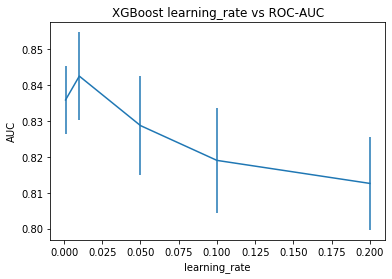

In [38]:
# Summarize GridSearch CV results
learning_rate = [0.001,0.01,0.05,0.1,0.2]
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs ROC-AUC")
plt.xlabel('learning_rate')
plt.ylabel('AUC')

<br>
Best AUC is achieved with a learning rate of 0.01. AUC decreases as the scale of learning rate is increased. In the next step, we search for optimal learning rate values in the scale of 10E-02. We will explore a random search over this space.

<br>


In [44]:
# Tune for learning rate again at the scale of 0.01
learning_rate = np.sort(np.random.uniform(0.01,0.09,20))
params = {'learning_rate':learning_rate}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=710)
grid_search = GridSearchCV(xgb, params, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_scaled,np.ravel(y_train))

Best: 0.842212 using {'learning_rate': 0.01018551272567601}


Text(0, 0.5, 'AUC')

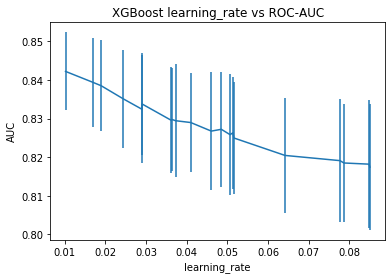

In [45]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs ROC-AUC")
plt.xlabel('learning_rate')
plt.ylabel('AUC')

We will now optimize the number of trees (n_estimators) at a learning rate of 0.01

#### Tune number of estimators and tree size

In [17]:
xgb2 = XGBClassifier(objective=objective_func,scale_pos_weight=weight,learning_rate=0.01)

params = {'n_estimators':[500,1000,2000,5000],'max_depth':[3,6,8,10]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=710)
grid_search = GridSearchCV(xgb2, params, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_scaled,np.ravel(y_train))

In [54]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_depth': 3, 'n_estimators': 500}
0.8466107746483968


In [18]:
# Repeat grid search
params = {'n_estimators':[100,200,300,400,500],'max_depth':[2,3,4]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=710)
grid_search = GridSearchCV(xgb2, params, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_scaled,np.ravel(y_train))

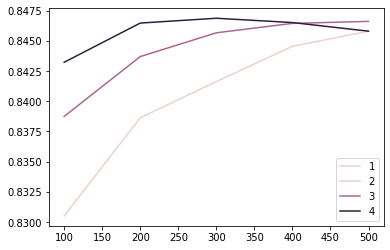

In [21]:
means = grid_result.cv_results_['mean_test_score']
estimators = grid_result.cv_results_['param_n_estimators']
depth = grid_result.cv_results_['param_max_depth']
sns.lineplot(x=estimators,y=means,hue=depth);


In [23]:
print('best param values: ',grid_result.best_params_)
print('best AUC value achieved: ',grid_result.best_score_)

best param values:  {'max_depth': 4, 'n_estimators': 300}
best AUC value achieved:  0.8468704970752737


#### Tune subsampling

In [15]:
xgb3 = XGBClassifier(objective=objective_func,scale_pos_weight=weight,learning_rate=0.01,max_depth = 4, n_estimators = 300)

In [26]:
# Grid search on subsampling

params = {'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,1.0]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=710)
grid_search = GridSearchCV(xgb3, params, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_scaled,np.ravel(y_train))

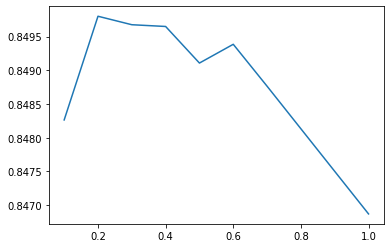

In [27]:
means = grid_result.cv_results_['mean_test_score']
estimators = grid_result.cv_results_['param_subsample']
sns.lineplot(x=estimators,y=means);

In [28]:
print('best param values: ',grid_result.best_params_)
print('best AUC value achieved: ',grid_result.best_score_)

best param values:  {'subsample': 0.2}
best AUC value achieved:  0.8498002254954657


### Fit selected model and monitor performance

In [29]:
# Final parameter values are:
# learning_rate = 0.01
# Trees = 300
# Max tree depth = 4
# Row subsample = 0.2

xgb_final = XGBClassifier(objective=objective_func,scale_pos_weight=weight,learning_rate=0.01,max_depth = 4, n_estimators = 300,subsample=0.2)

In [35]:
# Fit model on training set and monitor performance on an eval set
x_dev, x_eval, y_dev, y_eval = train_test_split(x_train,y_train,test_size=0.2,random_state = 710)
x_dev_scaled = scaler.transform(x_dev)
x_eval_scaled = scaler.transform(x_eval)

[0]	validation_0-auc:0.82198	validation_0-logloss:0.68937	validation_1-auc:0.79465	validation_1-logloss:0.68966
[1]	validation_0-auc:0.83611	validation_0-logloss:0.68572	validation_1-auc:0.80502	validation_1-logloss:0.68628
[2]	validation_0-auc:0.84990	validation_0-logloss:0.68254	validation_1-auc:0.81831	validation_1-logloss:0.68311
[3]	validation_0-auc:0.85091	validation_0-logloss:0.67933	validation_1-auc:0.82312	validation_1-logloss:0.67988
[4]	validation_0-auc:0.85300	validation_0-logloss:0.67603	validation_1-auc:0.82644	validation_1-logloss:0.67663
[5]	validation_0-auc:0.85369	validation_0-logloss:0.67268	validation_1-auc:0.82548	validation_1-logloss:0.67346
[6]	validation_0-auc:0.85439	validation_0-logloss:0.66963	validation_1-auc:0.82538	validation_1-logloss:0.67061
[7]	validation_0-auc:0.85363	validation_0-logloss:0.66622	validation_1-auc:0.82693	validation_1-logloss:0.66724
[8]	validation_0-auc:0.85403	validation_0-logloss:0.66329	validation_1-auc:0.82811	validation_1-logloss:

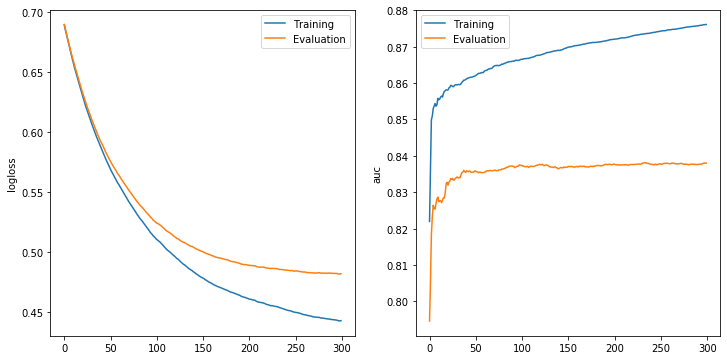

In [36]:
# Fit model and plot performance with Epochs
xgb_final.fit(x_dev_scaled, np.ravel(y_dev), eval_metric=["auc","logloss"], eval_set=[(x_dev_scaled,np.ravel(y_dev)),(x_eval_scaled,np.ravel(y_eval))], verbose=True)
results = xgb_final.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot learning curves

fig,axe = plt.subplots(1,2,figsize=(12,6));
sns.lineplot(x=x_axis,y=results['validation_0']['logloss'], label='Training',ax=axe[0]);
sns.lineplot(x=x_axis,y=results['validation_1']['logloss'], label='Evaluation',ax=axe[0]);
axe[0].legend();
axe[0].set_ylabel("logloss");
sns.lineplot(x=x_axis,y=results['validation_0']['auc'], label='Training',ax=axe[1]);
sns.lineplot(x=x_axis,y=results['validation_1']['auc'], label='Evaluation',ax=axe[1]);
axe[1].legend();
axe[1].set_ylabel("auc");


The learning curves suggest that training can be stopped after 100 iterations

### Feature Importance

In [53]:
feature_imp = list(map(float,list(xgb_final.feature_importances_)))
cols = list(x_train_df.columns)
feature_imp_df = pd.DataFrame({'Feature':cols,'Importance':feature_imp})
display(feature_imp_df)#.sort_values(by=['Importance'],inplace=True))

,Feature,Importance
0,tenure,0.035225
1,MonthlyCharges,0.026519
2,TotalCharges,0.026558
3,gender_Female,0.016671
4,SeniorCitizen_0,0.020781
5,Partner_No,0.018639
6,Dependents_No,0.022823
7,PhoneService_No,0.022453
8,MultipleLines_No,0.021916
9,MultipleLines_No phone service,0.000000


In [54]:
feature_imp_df.dtypes

Feature        object
Importance    float64
dtype: object

### Evaluate performance on test set

AUC:  0.8425925925925926
Confusion matrix at p=0.52: [[778 239]
 [ 97 293]]
True Positive Rate at p=0.52: 0.7512820512820513
True Negative Rate at p=0.52: 0.7649950835791544


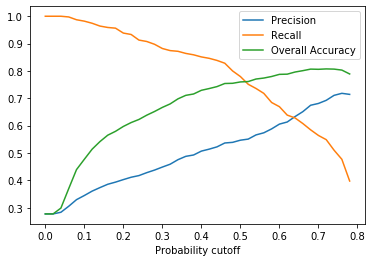

In [65]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Predict probabilities using model
prediction_output = xgb_final.predict_proba(X_test_Scaled)
# Select probability for churn events (Target = 1) and reshape
predicted_prob = prediction_output[:,1].reshape((y_test.shape[0],1))
observed = y_test.reshape((y_test.shape[0],1))
# Plot precision and recall across probabilities
prob_array = np.around(np.arange(0,0.8,0.02), decimals=2)
precision_array = np.zeros(prob_array.size)
recall_array = np.zeros(prob_array.size)
accuracy_array = np.zeros(prob_array.size)
i=0
for p in prob_array:
    prediction = (predicted_prob>=p)*1
    precision_array[i] = metrics.precision_score(observed,prediction)
    recall_array[i] = metrics.recall_score(observed,prediction)
    accuracy_array[i] = metrics.accuracy_score(observed,prediction)
    i=i+1

sns.lineplot(prob_array,precision_array,label="Precision");
sns.lineplot(prob_array,recall_array,label="Recall");
sns.lineplot(prob_array,accuracy_array,label="Overall Accuracy");
plt.xlabel("Probability cutoff");
plt.legend();

prediction = (predicted_prob>=0.52)*1
conf_matrix = confusion_matrix(observed,prediction)

print('AUC: ',roc_auc_score(observed,predicted_prob))
print('Confusion matrix at p=0.52:',conf_matrix)
print('True Positive Rate at p=0.52:',conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0]))
print('True Negative Rate at p=0.52:',conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[0,1]))